In [1]:
import numpy as np
import os
import kagglehub
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from scipy import stats

In [2]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self, ds_file, labels, transform=None):
        self.transform = transform
        data_np = np.load(ds_file)
        labels_np = np.load(labels)
        self.data = torch.from_numpy(data_np)
        self.labels = torch.from_numpy(labels_np)
        self.length = data_np.shape[0]
    def __len__(self):
        return self.length
    def __getitem__(self, index):
        if self.transform:
            self.data = self.transform(self.data)

        return self.data[index], self.labels[index]

Using Colab cache for faster access to the 'crowd-counting' dataset.
Path to dataset files: /kaggle/input/crowd-counting


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Average training label:  31.111224452427454
tensor([43], dtype=torch.uint8)


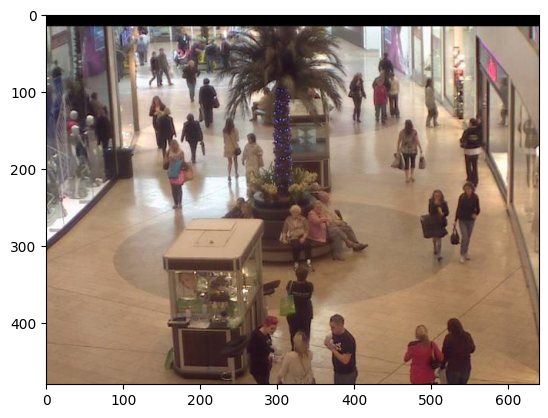

In [3]:
# Download latest version

path = kagglehub.dataset_download("fmena14/crowd-counting")
batch = 64

# train_data = np.load(os.path.join(path, "images.npy"))
all_data = DataSet(os.path.join(path, "images.npy"), os.path.join(path, "labels.npy"))
training_size = int(0.7 * len(all_data))
testing_size = (len(all_data)-training_size)

train_data, test_data = torch.utils.data.random_split(all_data, [training_size, testing_size])
labels = np.load(os.path.join(path, "labels.npy"))


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch, shuffle=False, num_workers=8)

print("Path to dataset files:", path)
labels_total = 0
for _, labels in train_loader:
  labels_total += torch.mean(labels.float()).item()

print("Average training label: ",(labels_total * batch)/len(train_data))

def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(npimg)



# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# print(images)


# show images
imshow(images[0])
print(labels[0])

In [4]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, 5)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 =  nn.Conv2d(32, 64, 5)
        self.bn3 = nn.BatchNorm2d(64)

        self.adaptive_pool = nn.AdaptiveMaxPool2d((12, 12))

        self.fc1 = nn.Linear(64*12*12, 120)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(120, 84)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(84, 60)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.adaptive_pool(x)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [5]:
def plot_graphs(title, train_graph, test_graph, file_name):
  fig, axes = plt.subplots(1,2)
  axes[0].plot(train_graph)
  axes[0].set_title("Training Accuracy")
  axes[0].set_xlabel("Epoch")
  axes[0].set_ylabel("Error (average number of people missed)")
  axes[1].plot(test_graph)
  axes[1].set_title("Testing Accuracy")
  axes[1].set_xlabel("Epoch")
  axes[1].set_ylabel("Error (average number of people missed)")
  fig.suptitle(title)
  fig.tight_layout()
  fig.show()
  fig.savefig(file_name)

In [6]:
epochs = 50
def train(network, device):
  test_acc = np.zeros(epochs)
  train_acc = np.zeros(epochs)
  for epoch in range(epochs):  # loop over the dataset multiple times
      correct = 0
      total = 0
      running_loss = 0.0
      running_acc = 0.0
      for i, data in enumerate(train_loader, 0):
          # get the inputs
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)
          labels_2d = torch.tensor(()).new_zeros((inputs.shape[0], 60))
          for j in range(inputs.shape[0]):
              labels_2d[j, labels[j].int()] = 1
          labels_2d = labels_2d.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = network(inputs.permute(0, 3, 2, 1).float())
          loss = criterion(outputs.float(), labels_2d.float())
          loss.backward()
          optimizer.step()
          predicted = torch.argmax(outputs, 1, keepdim=True)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          running_acc += torch.mean(torch.abs(predicted.float() - labels)).item() * labels.size(0)
          running_loss += loss.item()
      # train_acc[epoch] = running_loss/total
      train_acc[epoch] = running_acc/total
      print(running_loss)
      total = 0
      running_acc = 0.0
      with torch.no_grad():
          for data in test_loader:
              images, labels = data

              images = images.to(device)
              labels = labels.to(device)

              outputs = net(images.permute(0, 3, 2, 1).float())
              predicted = torch.argmax(outputs, 1, keepdim=True)
              total += labels.size(0)


              error = torch.mean(torch.abs(predicted.float() - labels)).item()
              running_acc += error * labels.size(0)
      test_acc[epoch] = running_acc/total
  plot_graphs("Simple CNN", train_acc, test_acc, "CNN_Plots")

In [7]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0003)

cuda
89.2835590839386
85.65298557281494
83.41573762893677
82.2040901184082
80.70941019058228
79.77805805206299
78.85504579544067
79.02166891098022
78.41368913650513
77.3277997970581
76.78635811805725
77.0496199131012
76.49715614318848
76.49331331253052
76.10918354988098
75.79477906227112
75.83056259155273
75.93181133270264
75.34338879585266
75.01949858665466
74.93481063842773
74.47444891929626
74.06221890449524
74.01469397544861
73.58566951751709
72.82923817634583
72.6054015159607
72.49603652954102
72.8349039554596
72.24608135223389
71.49246835708618
71.81895065307617
71.7375545501709
70.53392672538757
71.03505253791809
70.87867379188538
71.10241031646729
70.3662645816803
69.95051574707031
69.75032186508179
69.27130246162415
68.49479699134827
68.56085896492004
69.00599002838135
68.77627062797546
68.40168452262878
68.43824172019958
67.72724986076355
67.1530134677887
67.76738381385803


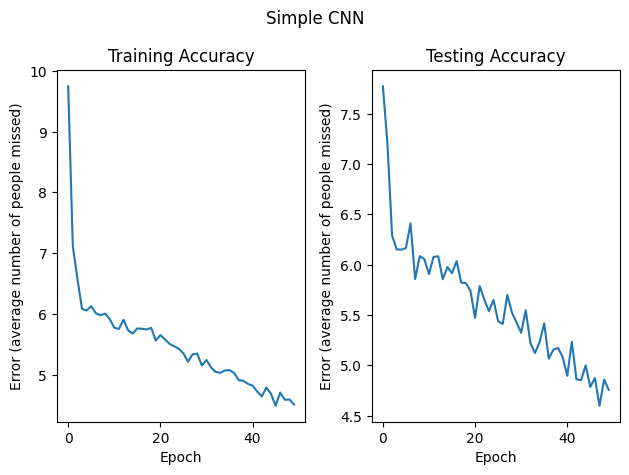

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
net = net.to(device)
train(net, device)

In [9]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

outputs = net(images.to(device).permute(0, 3, 2, 1).float())

predicted = torch.argmax(outputs, 1, keepdim=True)

print('Predicted: ', ' '.join('%5s' % predicted[j]
                              for j in range(4)))
# imshow(images[0])


print('Truth: ', ' '.join('%5s' % labels[j]
                              for j in range(4)))

predicted_data = np.zeros(0)
ground_truth_data = np.zeros(0)

total = 0.0
total_error = 0.0
with torch.no_grad():
    for data in test_loader:
        images, labels = data

        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images.permute(0, 3, 2, 1).float())
        predicted = torch.argmax(outputs, 1, keepdim=True)
        total += labels.size(0)

        # predicted_data = np.append(predicted_data, predicted.cpu().numpy())
        # ground_truth_data = np.append(ground_truth_data, labels.cpu().numpy())

        error = torch.mean(torch.abs(predicted.float() - labels))
        batch_size = labels.size(0)
        total_error += error * batch_size

# correlation, pvalue = stats.pearsonr(predicted_data, ground_truth_data)

# plt.scatter(predicted_data, ground_truth_data)
# plt.show()

# print("P-Value:", pvalue)

print('Average error on the test images (in number of people missed): %f ' %(
    total_error / total))

Predicted:  tensor([37], device='cuda:0') tensor([29], device='cuda:0') tensor([32], device='cuda:0') tensor([26], device='cuda:0')
Truth:  tensor([28], dtype=torch.uint8) tensor([27], dtype=torch.uint8) tensor([34], dtype=torch.uint8) tensor([30], dtype=torch.uint8)
Average error on the test images (in number of people missed): 4.708333 


In [10]:
#print(predicted_data)